# Preparation

### Loading dependencies

In [1]:
# Libraries 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tf_utils
from time import time
from datetime import date
import json
import pathlib
import albumentations as A

# Training

### Setting main parameters and seeds

In [2]:
# Parameters
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123
FPATH = 'D:/Master thesis/saved_models'

tf.random.set_seed(SEED)
np.random.seed(SEED)

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

### Loading datasets

In [ ]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
kaggle_ds = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = kaggle_ds.class_names
no_classes = len(class_names)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(kaggle_ds, train_part, valid_part, test_part, seed=SEED)
print(f'Batches ({BATCH_SIZE} images per batch) in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
kaggle_ds = kaggle_ds.map(tf_utils.normalize)
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize)
test_ds = test_ds.map(tf_utils.normalize)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Batches (32 images per batch) in subsets:
Train: 219
Validation: 47
Test: 48


### Importing the model

#### Inception

In [21]:
# Constructing a model
name = 'InceptionV3'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dropout(rate=0.4, seed=SEED))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

#### VGG

In [17]:
# Constructing a model
name = 'VGG19'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### ResNet

In [4]:
# Constructing a model
name = 'ResNet50'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1000, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### MobileNet

In [5]:
# Constructing a model
name = 'MobileNet'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Compiling the model and fitting

In [5]:
# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 75)                75075     
                                                                 
Total params: 25,711,787
Trainable params: 25,658,667
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

training_date = date.today()
model_dir_name = f'{model.name}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name)
model_dir_name += str(ctr)

print(model_dir_name)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model',
        monitor='val_accuracy',
        save_best_only=True
    )
]

t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds),
    callbacks=callbacks
)

training_time = time() - t0

ResNet50_(2023-04-13)_1
Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 1.8885 - accuracy: 0.5168

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/ResNet50_(2023-04-13)_1\model\assets


219/219 [==============================] - 547s 2s/step - loss: 1.8885 - accuracy: 0.5168 - val_loss: 5.7383 - val_accuracy: 0.0175
Epoch 2/100
217/219 [============================>.] - ETA: 3s - loss: 0.6529 - accuracy: 0.8026

KeyboardInterrupt: 

### Evaluation and saving

In [20]:
model = tf.keras.models.load_model(f'{FPATH}/{model_dir_name}/model')

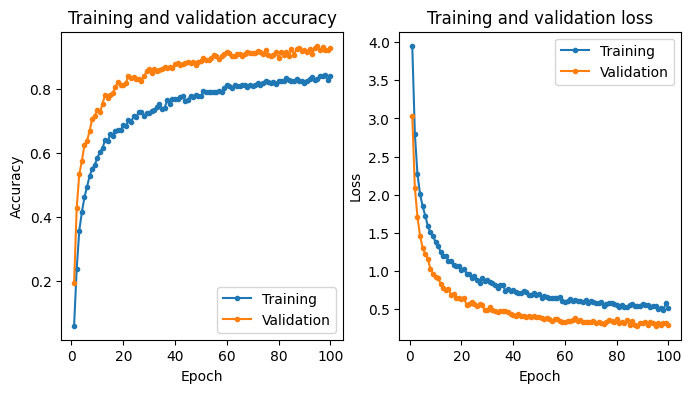

In [21]:
tf_utils.plot_history(history)

tf_utils.save_json(f'{FPATH}/{model_dir_name}/history.json', history.history)
#json.dump(history.history, open(f'{FPATH}/{model_dir_name}/history.json', 'w'))

In [22]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 80s 439ms/step - loss: 0.3065 - accuracy: 0.9199
Kaggle set evaluation: 
Test loss: 0.30653977394104004
Test accuracy: 0.919921875


1/1 [==============================] - 1s 1s/step


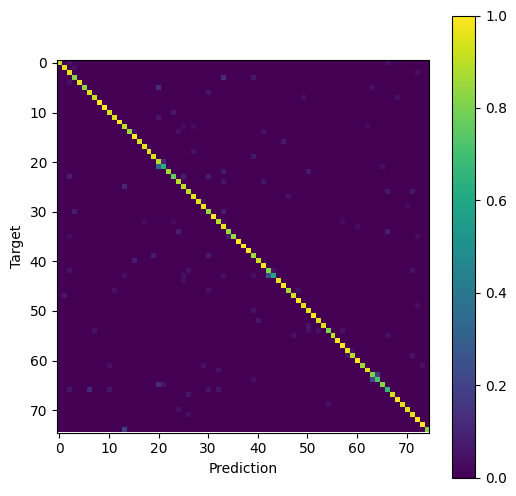

In [23]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m,figsize=(6,6))
plt.show()

In [24]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 8s 381ms/step - loss: 1.0195 - accuracy: 0.7029
Nature set evaluation: 
Test loss: 1.0194560289382935
Test accuracy: 0.7028985619544983


1/1 [==============================] - 4s 4s/step


d:\Master thesis\MasterThesis-1\tf_utils.py:182: RuntimeWarning: invalid value encountered in divide
  mat[i, :] /= normalization[i]


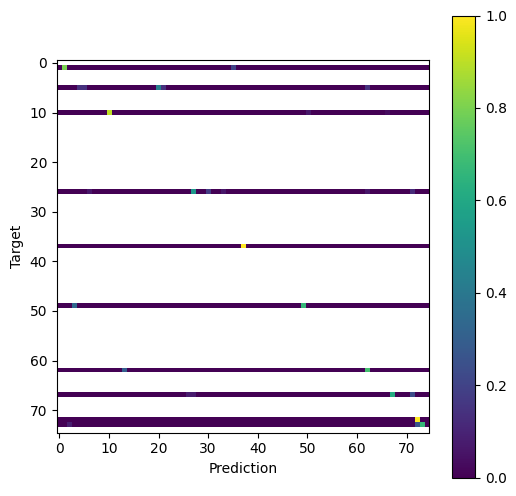

In [25]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m,figsize=(6,6))
plt.show()

In [26]:
# Evaluating inference time
t0 = time()
model.predict(kaggle_ds)
t1 = time()
inf_time = (t1 - t0) * 1000 / 10033

314/314 [==============================] - 142s 437ms/step


In [27]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'batch_size': BATCH_SIZE,
    'seed': SEED,
    'epochs': EPOCHS,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'inference_time': inf_time,
    'comment': '',
    'test_confusion': m.tolist(),
    'nature_confusion': nature_m.tolist()
    }

tf_utils.save_json(f'{FPATH}/{model_dir_name}/info.json', info)
#json.dump(info, open(f'{FPATH}/{model_dir_name}/info.json', 'w'))

# Influence of image quality

### Preparing functions required for transforming images

In [3]:
# Auxiliary functions
from tf_utils import transform_image, prepare_mapping, set_shapes

def test_transformed(model_paths, transforms, dataset, avg_amount=10):
    '''
    Performs series of tests of tensroflow models on given dataset transformed with some albumentations. For every model
    and every transformation results is averaged over `avg_amount` runs.

    Arguments:
        `model_paths`: list of paths to directories of models on which tests will be performed
        `transforms`: dictionary that should contain these three items:

            * list of albumentations to apply with key `list`\n
            * list of corresponding parameters controlling transformation with key `parameters`\n
            * name of transformation with key `name`
        `dataset`: tensorflow dataset of images on which models will be tested
        `avg_amount`: number of runs over which results will be averaged for every pair (model, transformation)

    Returns:
        `df`: pandas DataFrame with columns containing model's dictionary name, model's name, transformation parameter, loss and accuracy
    '''
    rows = []

    for path in model_paths:
        info = tf_utils.load_json(str(path) + '/info.json')
        np.random.seed(info['seed'])
        tf.random.set_seed(info['seed'])

        model = tf.keras.models.load_model(str(path) + '/model')
        print(f'Testing {path.name} in progress:')

        for itr, transform in enumerate(transforms['list']):
            print(f'\tTransform {itr+1}/{len(transforms["list"])}:')
            loss = 0
            accuracy = 0
            for itr2 in range(avg_amount):
                print(f'\t\t{itr2/avg_amount*100 : 3.0f}%', end='\r')

                tmp_ds = dataset.map(prepare_mapping(transform)).prefetch(tf.data.AUTOTUNE)
                tmp_ds = tmp_ds.map(set_shapes()).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

                tmp_loss, tmp_acc = model.evaluate(tmp_ds, verbose=False)
                loss += tmp_loss
                accuracy += tmp_acc

            print(f'\t\tLoss: {loss / avg_amount}, Accuracy: {accuracy / avg_amount}')
            rows.append({
                'saved_model': path.name,
                'model': model.name,
                'loss': loss / avg_amount,
                'accuracy': accuracy / avg_amount,
                transforms['name']: transforms['parameters'][itr]
            })
        
    df = pd.DataFrame(rows)
    return df

### Finding and choosing models

In [4]:
# Listing available models
model_paths = list(pathlib.Path(FPATH).glob('*'))
for i, p in enumerate(model_paths):
    info = tf_utils.load_json(str(p) + '/info.json')
    print(i, p.name, info['test_accuracy'], info['nature_accuracy'])

selected = model_paths[0:3] + model_paths[4:7] + model_paths[7:10]
selected

0 InceptionV3_(2023-04-07)_0 0.974609375 0.8695652484893799
1 InceptionV3_(2023-04-08)_0 0.9791666865348816 0.8550724983215332
2 InceptionV3_(2023-04-08)_1 0.9798177480697632 0.8405797481536865
3 MobileNetV2_(2023-03-24)_0 0.9596354365348816 0.8115942478179932
4 MobileNet_(2023-03-23)_0 0.9752604365348816 0.8333333730697632
5 MobileNet_(2023-04-09)_0 0.9778646230697632 0.8695652484893799
6 MobileNet_(2023-04-09)_1 0.982421875 0.9130434989929199
7 ResNet50v2_(2023-03-25)_0 0.9654948115348816 0.760869562625885
8 ResNet50v2_(2023-04-09)_0 0.9713541865348816 0.782608687877655
9 ResNet50v2_(2023-04-10)_0 0.9739583730697632 0.7898550629615784
10 ResNet_(2023-03-22)_1 0.9680989980697632 0.782608687877655
11 VGG16_(2023-03-20)_0 0.9420573115348816 0.7681159377098083
12 VGG16_(2023-04-10)_0 0.9466146230697632 0.782608687877655
13 VGG16_(2023-04-10)_1 0.9427083730697632 0.7898550629615784
14 VGG19_(2023-03-20)_0 0.9173177480697632 0.760869562625885
15 VGG19_(2023-04-11)_0 0.93359375 0.7101449370

[WindowsPath('D:/Master thesis/saved_models/InceptionV3_(2023-04-07)_0'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_(2023-04-08)_0'),
 WindowsPath('D:/Master thesis/saved_models/InceptionV3_(2023-04-08)_1'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_(2023-03-23)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_(2023-04-09)_0'),
 WindowsPath('D:/Master thesis/saved_models/MobileNet_(2023-04-09)_1'),
 WindowsPath('D:/Master thesis/saved_models/ResNet50v2_(2023-03-25)_0'),
 WindowsPath('D:/Master thesis/saved_models/ResNet50v2_(2023-04-09)_0'),
 WindowsPath('D:/Master thesis/saved_models/ResNet50v2_(2023-04-10)_0')]

### Loading the testing dataset

In [5]:
# Loading the dataset
ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=None
)

ds = ds.map(tf_utils.normalize).prefetch(tf.data.AUTOTUNE)

Found 138 files belonging to 75 classes.


### Running tests

#### Brightness

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 70.5132908821106, Accuracy: 1.7391304671764374
	Transform 2/19:
		Loss: 28.653287649154663, Accuracy: 5.579710006713867
	Transform 3/19:
		Loss: 15.92212700843811, Accuracy: 6.9565218687057495
	Transform 4/19:
		Loss: 11.485658288002014, Accuracy: 7.536231875419617
	Transform 5/19:
		Loss: 8.49070531129837, Accuracy: 8.115941882133484
	Transform 6/19:
		Loss: 7.312748730182648, Accuracy: 8.333333134651184
	Transform 7/19:
		Loss: 6.754623055458069, Accuracy: 8.47826063632965
	Transform 8/19:
		Loss: 6.332069098949432, Accuracy: 8.695651888847351
	Transform 9/19:
		Loss: 6.0786784291267395, Accuracy: 8.623188138008118
	Transform 10/19:
		Loss: 5.897654473781586, Accuracy: 8.695651888847351
	Transform 11/19:
		Loss: 5.995318353176117, Accuracy: 8.623188138008118
	Transform 12/19:
		Loss: 6.269143223762512, Accuracy: 8.623188138008118
	Transform 13/19:
		Loss: 7.017915487289429, Accuracy: 8.405796885490417
	Transform

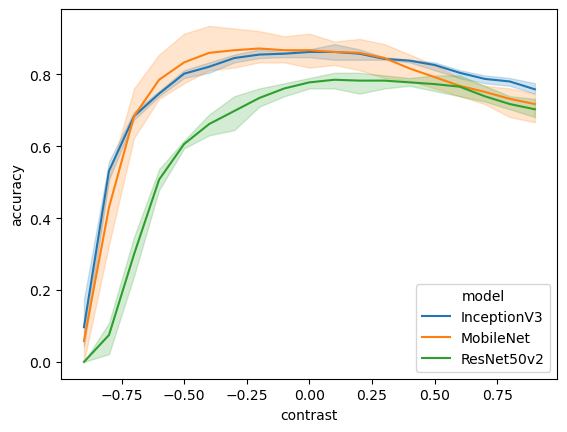

In [40]:
params = np.arange(-0.9, 1, 0.1)
transforms_list = [A.RandomBrightnessContrast(brightness_limit=(i,i), contrast_limit=(0,0), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'brightness'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()
df.to_csv('image quality results/' + transforms['name'] + '.csv')


#### Contrast

In [ ]:
params = np.arange(-0.9, 1, 0.1)
transforms_list = [A.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(i,i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'contrast'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()
df.to_csv('image quality results/' + transforms['name']+'.csv')

#### Gaussian noise

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.6031642019748688, Accuracy: 0.8768115997314453
	Transform 2/19:
		Loss: 0.6108841478824616, Accuracy: 0.8840579926967621
	Transform 3/19:
		Loss: 0.6407016694545746, Accuracy: 0.8731883943080903
	Transform 4/19:
		Loss: 0.6664171338081359, Accuracy: 0.8630434572696686
	Transform 5/19:
		Loss: 0.7269252479076386, Accuracy: 0.8536231637001037
	Transform 6/19:
		Loss: 0.8416442692279815, Accuracy: 0.8384057760238648
	Transform 7/19:
		Loss: 1.0536759316921234, Accuracy: 0.810869550704956
	Transform 8/19:
		Loss: 1.2296832919120788, Accuracy: 0.786956512928009
	Transform 9/19:
		Loss: 1.504951786994934, Accuracy: 0.7695652127265931
	Transform 10/19:
		Loss: 1.794931137561798, Accuracy: 0.7420289874076843
	Transform 11/19:
		Loss: 2.0523473739624025, Accuracy: 0.7057971119880676
	Transform 12/19:
		Loss: 2.4808592557907105, Accuracy: 0.6137680947780609
	Transform 13/19:
		Loss: 3.2801411151885986, Accuracy: 0.4557971

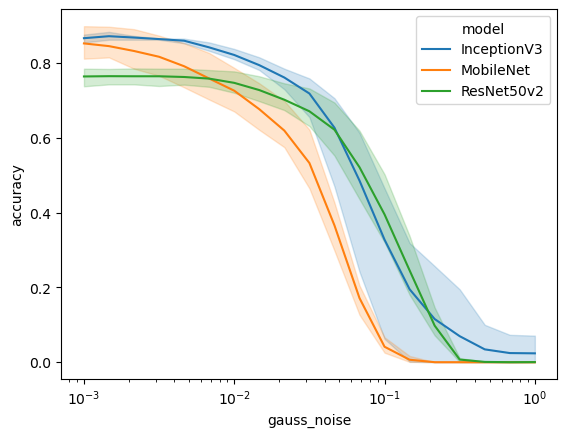

In [142]:
params = np.logspace(-3, 0, 19)
transforms_list = [A.GaussNoise(var_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_noise'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'.csv')

#### Gamma

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 9.556099891662598, Accuracy: 0.07246376574039459
	Transform 2/19:
		Loss: 9.513021183013915, Accuracy: 0.07246376574039459
	Transform 3/19:
		Loss: 9.415106296539307, Accuracy: 0.07246376574039459
	Transform 4/19:
		Loss: 9.136446952819824, Accuracy: 0.07246376574039459
	Transform 5/19:
		Loss: 6.619854402542114, Accuracy: 0.239130437374115
	Transform 6/19:
		Loss: 3.8229230403900147, Accuracy: 0.4275362193584442
	Transform 7/19:
		Loss: 2.1977416038513184, Accuracy: 0.6376811861991882
	Transform 8/19:
		Loss: 1.2101887583732605, Accuracy: 0.7898550629615784
	Transform 9/19:
		Loss: 0.8068097233772278, Accuracy: 0.8333333134651184
	Transform 10/19:
		Loss: 0.5897654473781586, Accuracy: 0.8695651888847351
	Transform 11/19:
		Loss: 0.5364249467849731, Accuracy: 0.8695651888847351
	Transform 12/19:
		Loss: 0.7924931704998016, Accuracy: 0.7898550629615784
	Transform 13/19:
		Loss: 2.089662528038025, Accuracy: 0.594202

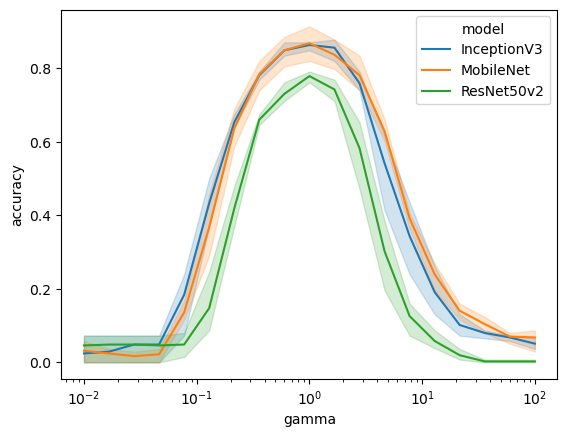

In [47]:
params = np.logspace(0,4,19)
transforms_list = [A.RandomGamma(gamma_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gamma'
}

df = test_transformed(selected, transforms, nature_ds, 10)

df[transforms['name']] /= 100 # Actual gamma parameter is 100 times smaller than the one passed to albumentations

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.xscale('log')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'.csv')

#### Image compression

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:


c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 3.774340295791626, Accuracy: 0.47101449966430664
	Transform 2/19:
		Loss: 3.7575032711029053, Accuracy: 0.47826087474823
	Transform 3/19:
		Loss: 3.709665870666504, Accuracy: 0.49275362491607666
	Transform 4/19:
		Loss: 2.7711339712142946, Accuracy: 0.5652173757553101
	Transform 5/19:
		Loss: 2.6726780414581297, Accuracy: 0.6086956262588501
	Transform 6/19:
		Loss: 2.1426677942276, Accuracy: 0.6449275612831116
	Transform 7/19:
		Loss: 1.8413563013076781, Accuracy: 0.6666666865348816
	Transform 8/19:
		Loss: 1.6849759936332702, Accuracy: 0.7101449370384216
	Transform 9/19:
		Loss: 1.4956363201141358, Accuracy: 0.717391312122345
	Transform 10/19:
		Loss: 1.422515618801117, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.200235867500305, Accuracy: 0.7898550629615784
	Transform 12/19:
		Loss: 1.0577760457992553, Accuracy: 0.8188405632972717
	Transform 13/19:
		Loss: 0.9691285729408264, Accuracy: 0.8405796885490417
	Transform 14/19:
		Loss: 0.8451422154903412, Accuracy: 0.84

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 3.1105535507202147, Accuracy: 0.5289855003356934
	Transform 2/19:
		Loss: 3.116815209388733, Accuracy: 0.5289855003356934
	Transform 3/19:
		Loss: 3.160045313835144, Accuracy: 0.5507246255874634
	Transform 4/19:
		Loss: 2.4479806661605834, Accuracy: 0.6594203114509583
	Transform 5/19:
		Loss: 2.619631314277649, Accuracy: 0.6521739363670349
	Transform 6/19:
		Loss: 2.2365714073181153, Accuracy: 0.6884058117866516
	Transform 7/19:
		Loss: 1.8989810943603516, Accuracy: 0.7028985619544983
	Transform 8/19:
		Loss: 1.7103325963020324, Accuracy: 0.7318840622901917
	Transform 9/19:
		Loss: 1.5221626996994018, Accuracy: 0.7463768124580383
	Transform 10/19:
		Loss: 1.4830313086509705, Accuracy: 0.739130437374115
	Transform 11/19:
		Loss: 1.298820185661316, Accuracy: 0.7681159377098083
	Transform 12/19:
		Loss: 1.1166515350341797, Accuracy: 0.782608687877655
	Transform 13/19:
		Loss: 1.019221580028534, Accuracy: 0.8115941882133484
	Transform 14/19:
		Loss: 0.9614830732345581, Accuracy: 0.

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 2.918421673774719, Accuracy: 0.5362318754196167
	Transform 2/19:
		Loss: 2.923040437698364, Accuracy: 0.5362318754196167
	Transform 3/19:
		Loss: 2.667151165008545, Accuracy: 0.5652173757553101
	Transform 4/19:
		Loss: 2.076854205131531, Accuracy: 0.6449275612831116
	Transform 5/19:
		Loss: 1.9430635929107667, Accuracy: 0.7246376872062683
	Transform 6/19:
		Loss: 1.6588927507400513, Accuracy: 0.7246376872062683
	Transform 7/19:
		Loss: 1.3209473848342896, Accuracy: 0.760869562625885
	Transform 8/19:
		Loss: 1.05894216299057, Accuracy: 0.7681159377098083
	Transform 9/19:
		Loss: 0.9297120690345764, Accuracy: 0.7753623127937317
	Transform 10/19:
		Loss: 0.93764888048172, Accuracy: 0.7898550629615784
	Transform 11/19:
		Loss: 0.9278871297836304, Accuracy: 0.804347813129425
	Transform 12/19:
		Loss: 0.7573856770992279, Accuracy: 0.8115941882133484
	Transform 13/19:
		Loss: 0.6368393659591675, Accuracy: 0.8333333134651184
	Transform 14/19:
		Loss: 0.6303203046321869, Accuracy: 0.840

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 6.533331346511841, Accuracy: 0.3188405930995941
	Transform 2/19:
		Loss: 6.49124116897583, Accuracy: 0.3333333432674408
	Transform 3/19:
		Loss: 6.111760807037354, Accuracy: 0.3695652186870575
	Transform 4/19:
		Loss: 4.711636781692505, Accuracy: 0.4202898442745209
	Transform 5/19:
		Loss: 3.412993597984314, Accuracy: 0.49275362491607666
	Transform 6/19:
		Loss: 2.6315871238708497, Accuracy: 0.5652173757553101
	Transform 7/19:
		Loss: 2.307703948020935, Accuracy: 0.6014492511749268
	Transform 8/19:
		Loss: 2.063913369178772, Accuracy: 0.6304348111152649
	Transform 9/19:
		Loss: 1.860591721534729, Accuracy: 0.6449275612831116
	Transform 10/19:
		Loss: 1.8589860916137695, Accuracy: 0.717391312122345
	Transform 11/19:
		Loss: 1.5980029582977295, Accuracy: 0.7463768124580383
	Transform 12/19:
		Loss: 1.480849289894104, Accuracy: 0.7681159377098083
	Transform 13/19:
		Loss: 1.3580866694450378, Accuracy: 0.7898550629615784
	Transform 14/19:
		Loss: 1.3146991848945617, Accuracy: 0.797

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 4.139761447906494, Accuracy: 0.4057970941066742
	Transform 2/19:
		Loss: 4.120168876647949, Accuracy: 0.4057970941066742
	Transform 3/19:
		Loss: 4.051485967636109, Accuracy: 0.43478259444236755
	Transform 4/19:
		Loss: 3.6228824138641356, Accuracy: 0.4637681245803833
	Transform 5/19:
		Loss: 3.1044931411743164, Accuracy: 0.5144927501678467
	Transform 6/19:
		Loss: 2.7687346935272217, Accuracy: 0.54347825050354
	Transform 7/19:
		Loss: 2.251527523994446, Accuracy: 0.6086956262588501
	Transform 8/19:
		Loss: 1.9579787254333496, Accuracy: 0.6594203114509583
	Transform 9/19:
		Loss: 1.7574317455291748, Accuracy: 0.6449275612831116
	Transform 10/19:
		Loss: 1.7780412435531616, Accuracy: 0.6666666865348816
	Transform 11/19:
		Loss: 1.3686243176460267, Accuracy: 0.739130437374115
	Transform 12/19:
		Loss: 1.122394609451294, Accuracy: 0.7318840622901917
	Transform 13/19:
		Loss: 0.9637794733047486, Accuracy: 0.760869562625885
	Transform 14/19:
		Loss: 0.9774491310119628, Accuracy: 0.7

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 6.283239459991455, Accuracy: 0.37681159377098083
	Transform 2/19:
		Loss: 6.33051381111145, Accuracy: 0.3695652186870575
	Transform 3/19:
		Loss: 5.686257457733154, Accuracy: 0.4202898442745209
	Transform 4/19:
		Loss: 3.848293161392212, Accuracy: 0.5289855003356934
	Transform 5/19:
		Loss: 2.816187310218811, Accuracy: 0.6304348111152649
	Transform 6/19:
		Loss: 2.3418842792510985, Accuracy: 0.695652186870575
	Transform 7/19:
		Loss: 1.6334243893623352, Accuracy: 0.739130437374115
	Transform 8/19:
		Loss: 1.5231862545013428, Accuracy: 0.760869562625885
	Transform 9/19:
		Loss: 1.2216484069824218, Accuracy: 0.8115941882133484
	Transform 10/19:
		Loss: 1.2078903436660766, Accuracy: 0.782608687877655
	Transform 11/19:
		Loss: 0.8073122382164002, Accuracy: 0.8405796885490417
	Transform 12/19:
		Loss: 0.8029170334339142, Accuracy: 0.8550724387168884
	Transform 13/19:
		Loss: 0.6603474318981171, Accuracy: 0.8695651888847351
	Transform 14/19:
		Loss: 0.6369265139102935, Accuracy: 0.85

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 7.654739475250244, Accuracy: 0.3840579688549042
	Transform 2/19:
		Loss: 7.631271171569824, Accuracy: 0.3840579688549042
	Transform 3/19:
		Loss: 6.864835023880005, Accuracy: 0.3913043439388275
	Transform 4/19:
		Loss: 4.8387682914733885, Accuracy: 0.4637681245803833
	Transform 5/19:
		Loss: 3.932289242744446, Accuracy: 0.5579710006713867
	Transform 6/19:
		Loss: 3.1781890392303467, Accuracy: 0.5942028760910034
	Transform 7/19:
		Loss: 2.6228404998779298, Accuracy: 0.6014492511749268
	Transform 8/19:
		Loss: 2.39215087890625, Accuracy: 0.6304348111152649
	Transform 9/19:
		Loss: 2.2732815742492676, Accuracy: 0.6594203114509583
	Transform 10/19:
		Loss: 2.303854727745056, Accuracy: 0.6739130616188049
	Transform 11/19:
		Loss: 2.220029377937317, Accuracy: 0.695652186870575
	Transform 12/19:
		Loss: 2.1447463750839235, Accuracy: 0.7246376872062683
	Transform 13/19:
		Loss: 2.0915114879608154, Accuracy: 0.717391312122345
	Transform 14/19:
		Loss: 1.9843405723571776, Accuracy: 0.739

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 5.266203451156616, Accuracy: 0.47826087474823
	Transform 2/19:
		Loss: 5.272489547729492, Accuracy: 0.47826087474823
	Transform 3/19:
		Loss: 4.944540548324585, Accuracy: 0.47101449966430664
	Transform 4/19:
		Loss: 3.7707875251770018, Accuracy: 0.5724637508392334
	Transform 5/19:
		Loss: 3.1474992990493775, Accuracy: 0.6811594367027283
	Transform 6/19:
		Loss: 2.8632341861724853, Accuracy: 0.695652186870575
	Transform 7/19:
		Loss: 2.633194327354431, Accuracy: 0.739130437374115
	Transform 8/19:
		Loss: 2.3909982204437257, Accuracy: 0.7536231875419617
	Transform 9/19:
		Loss: 2.3023279190063475, Accuracy: 0.739130437374115
	Transform 10/19:
		Loss: 2.39186315536499, Accuracy: 0.7536231875419617
	Transform 11/19:
		Loss: 2.2418468713760378, Accuracy: 0.782608687877655
	Transform 12/19:
		Loss: 2.213045525550842, Accuracy: 0.7753623127937317
	Transform 13/19:
		Loss: 2.2258508682250975, Accuracy: 0.7753623127937317
	Transform 14/19:
		Loss: 2.1583085298538207, Accuracy: 0.7753623

c:\Users\User\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


		Loss: 5.272618007659912, Accuracy: 0.5869565010070801
	Transform 2/19:
		Loss: 5.260151195526123, Accuracy: 0.5869565010070801
	Transform 3/19:
		Loss: 4.956619691848755, Accuracy: 0.5797101259231567
	Transform 4/19:
		Loss: 4.460313701629639, Accuracy: 0.6811594367027283
	Transform 5/19:
		Loss: 3.942967438697815, Accuracy: 0.6739130616188049
	Transform 6/19:
		Loss: 3.400480628013611, Accuracy: 0.695652186870575
	Transform 7/19:
		Loss: 3.401009678840637, Accuracy: 0.739130437374115
	Transform 8/19:
		Loss: 3.0505440711975096, Accuracy: 0.739130437374115
	Transform 9/19:
		Loss: 3.003540301322937, Accuracy: 0.7536231875419617
	Transform 10/19:
		Loss: 3.053498721122742, Accuracy: 0.7536231875419617
	Transform 11/19:
		Loss: 2.699475955963135, Accuracy: 0.7681159377098083
	Transform 12/19:
		Loss: 2.588721227645874, Accuracy: 0.7681159377098083
	Transform 13/19:
		Loss: 2.5355926513671876, Accuracy: 0.760869562625885
	Transform 14/19:
		Loss: 2.4841402769088745, Accuracy: 0.76086956

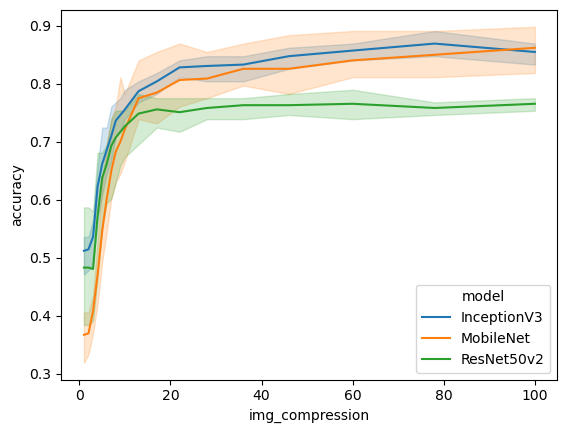

In [6]:
params = [1,2,3,4,5,6,7,8,9,10,13,17,22,28,36,46,60,78,100]
transforms_list = [A.ImageCompression(quality_lower=i, quality_upper=i, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'img_compression'
}

df = test_transformed(selected, transforms, ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'.csv')

#### Gaussian blur

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.5897654354572296, Accuracy: 0.8695651888847351
	Transform 2/19:
		Loss: 0.6692057847976685, Accuracy: 0.8550724387168884
	Transform 3/19:
		Loss: 0.7896425008773804, Accuracy: 0.8405796885490417
	Transform 4/19:
		Loss: 1.0494293093681335, Accuracy: 0.8188405632972717
	Transform 5/19:
		Loss: 1.2758109807968139, Accuracy: 0.782608687877655
	Transform 6/19:
		Loss: 1.4962961554527283, Accuracy: 0.739130437374115
	Transform 7/19:
		Loss: 1.8432701110839844, Accuracy: 0.6739130616188049
	Transform 8/19:
		Loss: 2.4035842418670654, Accuracy: 0.5942028760910034
	Transform 9/19:
		Loss: 3.0523616790771486, Accuracy: 0.52173912525177
	Transform 10/19:
		Loss: 3.72802894115448, Accuracy: 0.47101449966430664
	Transform 11/19:
		Loss: 4.479701519012451, Accuracy: 0.3333333432674408
	Transform 12/19:
		Loss: 5.346041011810303, Accuracy: 0.2028985470533371
	Transform 13/19:
		Loss: 6.283002185821533, Accuracy: 0.08695652335

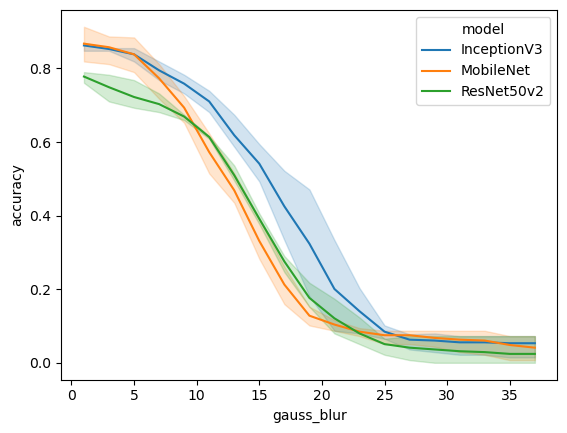

In [174]:
params = np.arange(1, 39, 2)
transforms_list = [A.GaussianBlur(blur_limit=(i, i), always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'gauss_blur'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'.csv')

#### Motion blur

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.6211290478706359, Accuracy: 0.8615941882133484
	Transform 2/19:
		Loss: 0.801071721315384, Accuracy: 0.8413043260574341
	Transform 3/19:
		Loss: 1.3576412916183471, Accuracy: 0.7746376752853393
	Transform 4/19:
		Loss: 2.238227701187134, Accuracy: 0.6449275493621827
	Transform 5/19:
		Loss: 3.1095695972442625, Accuracy: 0.556521725654602
	Transform 6/19:
		Loss: 4.2695060014724735, Accuracy: 0.4420289874076843
	Transform 7/19:
		Loss: 5.17979097366333, Accuracy: 0.36521739363670347
	Transform 8/19:
		Loss: 5.868490934371948, Accuracy: 0.31739130318164827
	Transform 9/19:
		Loss: 6.447264194488525, Accuracy: 0.28695652186870574
	Transform 10/19:
		Loss: 6.982268953323365, Accuracy: 0.24347825944423676
	Transform 11/19:
		Loss: 7.4160669326782225, Accuracy: 0.21666666567325593
	Transform 12/19:
		Loss: 7.9551044464111325, Accuracy: 0.18260869681835173
	Transform 13/19:
		Loss: 8.04686393737793, Accuracy: 0.1782608

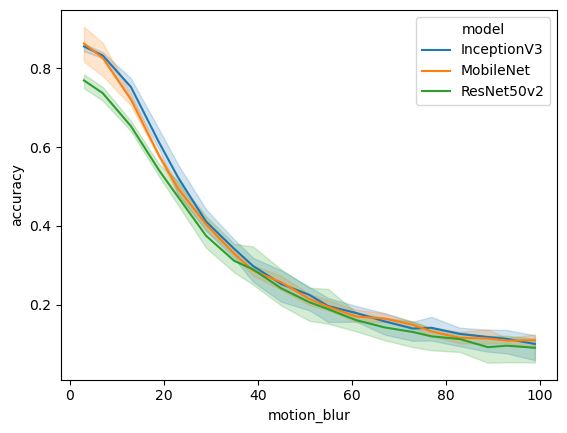

In [182]:
params = np.array(list(map(lambda x: x if x%2==1 else x-1, np.linspace(3,100,19).astype(int))))

transforms_list = [A.MotionBlur(blur_limit=(i, i), allow_shifted=False, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'motion_blur'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'.csv')

#### Downscale

In [19]:
params = np.logspace(-2,0,19,endpoint=False)

transforms_list = [A.Downscale(scale_min=i, scale_max=i, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'downscale'
}

df = test_transformed(selected, transforms, nature_ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'.csv')

c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:


ValueError: in user code:

    File "d:\Master thesis\MasterThesis-1\tf_utils.py", line 306, in inner  *
        label.set_shape([])

    ValueError: Shapes must be equal rank, but are 1 and 0


#### Rotation

Testing InceptionV3_(2023-04-07)_0 in progress:
	Transform 1/19:
		Loss: 0.5897653043270111, Accuracy: 0.8695652484893799
	Transform 2/19:
		Loss: 0.698939198255539, Accuracy: 0.8188406229019165
	Transform 3/19:
		Loss: 0.6024623274803161, Accuracy: 0.8623188734054565
	Transform 4/19:
		Loss: 0.5366772770881653, Accuracy: 0.8695652484893799
	Transform 5/19:
		Loss: 0.5502060532569886, Accuracy: 0.8840579986572266
	Transform 6/19:
		Loss: 0.8455205678939819, Accuracy: 0.8333333730697632
	Transform 7/19:
		Loss: 1.044107449054718, Accuracy: 0.7101449370384216
	Transform 8/19:
		Loss: 1.2680810332298278, Accuracy: 0.6739130616188049
	Transform 9/19:
		Loss: 1.303928303718567, Accuracy: 0.6811594367027283
	Transform 10/19:
		Loss: 1.29655020236969, Accuracy: 0.6739130616188049
	Transform 11/19:
		Loss: 1.5275967121124268, Accuracy: 0.695652186870575
	Transform 12/19:
		Loss: 1.7082676768302918, Accuracy: 0.6594203114509583
	Transform 13/19:
		Loss: 1.5267395615577697, Accuracy: 0.695652186

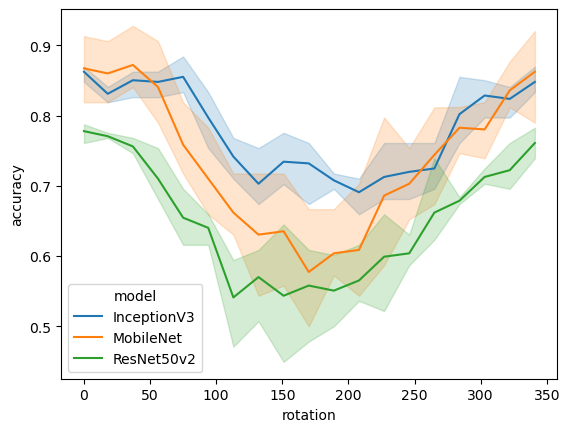

In [7]:
params = np.linspace(0, 360, 19, endpoint=False, dtype=int)
from cv2 import BORDER_REPLICATE
transforms_list = [A.Rotate(limit=(i,i), border_mode=BORDER_REPLICATE, always_apply=True) for i in params]
transforms = {
    'list': transforms_list,
    'parameters': params,
    'name': 'rotation'
}

df = test_transformed(selected, transforms, ds, 10)

sns.lineplot(data=df, x=transforms['name'], y='accuracy', hue='model')
plt.show()

df.to_csv('image quality results/' + transforms['name']+'.csv')

# Augmentation

### Setting main parameters and seeds

In [2]:
# Parameters
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123
FPATH = 'D:/Master thesis/saved_models'
AUGMENTAION_PROPORTION = 1.0

tf.random.set_seed(SEED)
np.random.seed(SEED)

tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:GPU:1', device_type='GPU')]

### Loading datasets

In [17]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
kaggle_ds = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=None
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = kaggle_ds.class_names
no_classes = len(class_names)
no_images = len(kaggle_ds)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(kaggle_ds, train_part, valid_part, test_part, seed=SEED)
print(f'Images in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
kaggle_ds = kaggle_ds.map(tf_utils.normalize).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(tf_utils.normalize).batch(BATCH_SIZE)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Images in subsets:
Train: 7023
Validation: 1504
Test: 1506


### Preparing augmentations

- Brightness limits: (-0.6, 0.6) or (-0.6, -0.3)+(0.3, 0.6) -> indexes (3, 6)+(12, 15)
- Contrast limits: (-0.8, -0.4)+(0.4, 0.8) -> indexes (1, 5)+(13, 17)
- Gamma correction: (,)-> indexes (5, 8)+(10, 13)
- Gaussian noise: (1e-3, 5e-2) -> indexes (0, 10)
- Gaussian blur: (1, 13) -> indexes (0, 6)
- Motion blur: (,) -> indexes (1, 4)
- Image compression: (1, 19) -> indexes (0, 11)
- Downscaling: (,) -> indexes (12, 16)
- Rotation: (75, 282) -> indexes (4, 15)

In [5]:
brightness_params = np.linspace(-0.9, 0.9, 19)
contrast_params = np.linspace(-0.9, 0.9, 19)
gamma_params = np.logspace(0, 4, 19)
gauss_noise_params = np.logspace(-3, 0, 19)
gauss_blur_params = np.arange(1, 39, 2)
motion_blur_params = np.array(list(map(lambda x: x if x % 2 == 1 else x - 1, np.linspace(3, 100, 19).astype(int))))
image_compression_params = [1,2,3,4,5,6,7,8,9,10,13,17,22,28,36,46,60,78,100]
downscale_params = np.logspace(-2, 0, 19, endpoint=False)
rotation_params = np.linspace(0, 360, 19, endpoint=False, dtype=int)

from cv2 import BORDER_REPLICATE

transforms = [
    A.RandomBrightnessContrast(brightness_limit=(brightness_params[3], brightness_params[6]), contrast_limit=0),
    A.RandomBrightnessContrast(brightness_limit=(brightness_params[12], brightness_params[15]), contrast_limit=0),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(contrast_params[1], contrast_params[5])),
    A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(contrast_params[13], contrast_params[17])),
    A.RandomGamma(gamma_limit=(gamma_params[5], gamma_params[8])),
    A.RandomGamma(gamma_limit=(gamma_params[10], gamma_params[13])),
    A.GaussNoise(var_limit=(gauss_noise_params[0], gauss_noise_params[10])),
    A.GaussianBlur(blur_limit=(gauss_blur_params[0], gauss_blur_params[6])),
    A.MotionBlur(blur_limit=(motion_blur_params[1], motion_blur_params[4])),
    A.ImageCompression(quality_lower=image_compression_params[0], quality_upper=image_compression_params[11]),
    A.Downscale(scale_min=downscale_params[12], scale_max=downscale_params[16]),
    A.Rotate(limit=(rotation_params[4], rotation_params[15]), border_mode=BORDER_REPLICATE)
]

augmentation = A.OneOf(transforms, AUGMENTAION_PROPORTION)

c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


### Augmenting dataset

In [6]:
train_ds = train_ds\
    .map(tf_utils.prepare_mapping(augmentation))\
    .map(tf_utils.set_shapes())\
    .batch(BATCH_SIZE)\
    .cache()\
    .prefetch(tf.data.AUTOTUNE)

### Importing the model

#### Inception

In [7]:
# Constructing a model
name = 'InceptionV3'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dropout(rate=0.4, seed=SEED))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

#### MobileNet

In [ ]:
# Constructing a model
name = 'MobileNet'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='avg'
)

pretrained.summary()

# Disabling training of pretrained layers
#pretrained.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

### Compiling the model and fitting

In [8]:
# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 75)                153675    
                                                                 
Total params: 21,956,459
Trainable params: 21,922,027
Non-trainable params: 34,432
_________________________________________________________________


In [9]:
training_date = date.today()
model_dir_name = f'{model.name}_aug{AUGMENTAION_PROPORTION * 100:.0f}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name)
model_dir_name += str(ctr)

print(model_dir_name)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model',
        monitor='val_accuracy',
        save_best_only=True
    )
]

t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds),
    callbacks=callbacks
)

training_time = time() - t0

InceptionV3_aug100_(2023-05-10)_1
Epoch 1/100


c:\Users\Admin\anaconda3\envs\tf_direct\lib\site-packages\albumentations\augmentations\functional.py:485: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


220/220 [==============================] - ETA: 0s - loss: 2.2059 - accuracy: 0.4444

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 210s 815ms/step - loss: 2.2059 - accuracy: 0.4444 - val_loss: 2.9233 - val_accuracy: 0.3684
Epoch 2/100
220/220 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.7199

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 137s 620ms/step - loss: 0.9945 - accuracy: 0.7199 - val_loss: 1.1784 - val_accuracy: 0.7114
Epoch 3/100
220/220 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.8227

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 138s 625ms/step - loss: 0.5955 - accuracy: 0.8227 - val_loss: 1.1178 - val_accuracy: 0.7154
Epoch 4/100
220/220 [==============================] - 98s 443ms/step - loss: 0.4429 - accuracy: 0.8639 - val_loss: 1.3462 - val_accuracy: 0.7021
Epoch 5/100
220/220 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.9002

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 135s 614ms/step - loss: 0.3202 - accuracy: 0.9002 - val_loss: 0.6115 - val_accuracy: 0.8531
Epoch 6/100
220/220 [==============================] - 100s 451ms/step - loss: 0.2678 - accuracy: 0.9198 - val_loss: 0.6856 - val_accuracy: 0.8165
Epoch 7/100
220/220 [==============================] - 99s 452ms/step - loss: 0.1988 - accuracy: 0.9396 - val_loss: 2.2557 - val_accuracy: 0.6090
Epoch 8/100
220/220 [==============================] - ETA: 0s - loss: 0.1960 - accuracy: 0.9440

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 148s 673ms/step - loss: 0.1960 - accuracy: 0.9440 - val_loss: 0.5488 - val_accuracy: 0.8630
Epoch 9/100
220/220 [==============================] - 97s 442ms/step - loss: 0.1692 - accuracy: 0.9504 - val_loss: 0.7112 - val_accuracy: 0.8484
Epoch 10/100
220/220 [==============================] - 96s 437ms/step - loss: 0.1600 - accuracy: 0.9509 - val_loss: 0.7311 - val_accuracy: 0.8205
Epoch 11/100
220/220 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9537

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 136s 617ms/step - loss: 0.1559 - accuracy: 0.9537 - val_loss: 0.4517 - val_accuracy: 0.9003
Epoch 12/100
220/220 [==============================] - 95s 430ms/step - loss: 0.1532 - accuracy: 0.9536 - val_loss: 1.0463 - val_accuracy: 0.7812
Epoch 13/100
220/220 [==============================] - 94s 429ms/step - loss: 0.1343 - accuracy: 0.9577 - val_loss: 0.9394 - val_accuracy: 0.8118
Epoch 14/100
220/220 [==============================] - 96s 436ms/step - loss: 0.1039 - accuracy: 0.9677 - val_loss: 0.6834 - val_accuracy: 0.8624
Epoch 15/100
220/220 [==============================] - ETA: 0s - loss: 0.0687 - accuracy: 0.9801

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 133s 604ms/step - loss: 0.0687 - accuracy: 0.9801 - val_loss: 0.4352 - val_accuracy: 0.9156
Epoch 16/100
220/220 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9870

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 131s 593ms/step - loss: 0.0517 - accuracy: 0.9870 - val_loss: 0.4319 - val_accuracy: 0.9182
Epoch 17/100
220/220 [==============================] - 96s 434ms/step - loss: 0.1330 - accuracy: 0.9590 - val_loss: 0.6326 - val_accuracy: 0.8777
Epoch 18/100
220/220 [==============================] - 95s 432ms/step - loss: 0.1404 - accuracy: 0.9584 - val_loss: 0.7603 - val_accuracy: 0.8544
Epoch 19/100
220/220 [==============================] - 94s 426ms/step - loss: 0.1262 - accuracy: 0.9657 - val_loss: 0.6705 - val_accuracy: 0.8703
Epoch 20/100
220/220 [==============================] - 94s 428ms/step - loss: 0.1077 - accuracy: 0.9691 - val_loss: 0.4445 - val_accuracy: 0.9023
Epoch 21/100
220/220 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9831

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 133s 605ms/step - loss: 0.0571 - accuracy: 0.9831 - val_loss: 0.2895 - val_accuracy: 0.9475
Epoch 22/100
220/220 [==============================] - 96s 435ms/step - loss: 0.0443 - accuracy: 0.9868 - val_loss: 0.4551 - val_accuracy: 0.9129
Epoch 23/100
220/220 [==============================] - 96s 438ms/step - loss: 0.0800 - accuracy: 0.9766 - val_loss: 0.7052 - val_accuracy: 0.8664
Epoch 24/100
220/220 [==============================] - 96s 437ms/step - loss: 0.0844 - accuracy: 0.9727 - val_loss: 0.5168 - val_accuracy: 0.9116
Epoch 25/100
220/220 [==============================] - 96s 436ms/step - loss: 0.1049 - accuracy: 0.9701 - val_loss: 0.4559 - val_accuracy: 0.9069
Epoch 26/100
220/220 [==============================] - 94s 429ms/step - loss: 0.0762 - accuracy: 0.9785 - val_loss: 0.3310 - val_accuracy: 0.9375
Epoch 27/100
220/220 [==============================] - 94s 426ms/step - loss: 0.0534 - accuracy: 0.9849 - val_loss: 0.4570 - val_

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 152s 694ms/step - loss: 0.0201 - accuracy: 0.9942 - val_loss: 0.2693 - val_accuracy: 0.9588
Epoch 46/100
220/220 [==============================] - 117s 531ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.3185 - val_accuracy: 0.9388
Epoch 47/100
220/220 [==============================] - 132s 601ms/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.3777 - val_accuracy: 0.9428
Epoch 48/100
220/220 [==============================] - 132s 601ms/step - loss: 0.0278 - accuracy: 0.9927 - val_loss: 0.3786 - val_accuracy: 0.9328
Epoch 49/100
220/220 [==============================] - 132s 602ms/step - loss: 0.0409 - accuracy: 0.9890 - val_loss: 0.8836 - val_accuracy: 0.8504
Epoch 50/100
220/220 [==============================] - 134s 610ms/step - loss: 0.1577 - accuracy: 0.9584 - val_loss: 0.5597 - val_accuracy: 0.8996
Epoch 51/100
220/220 [==============================] - 133s 604ms/step - loss: 0.0556 - accuracy: 0.9831 - val_loss: 0.3523 

INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


INFO:tensorflow:Assets written to: D:/Master thesis/saved_models/InceptionV3_aug100_(2023-05-10)_1\model\assets


220/220 [==============================] - 298s 1s/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.2662 - val_accuracy: 0.9661
Epoch 82/100
220/220 [==============================] - 249s 1s/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.3096 - val_accuracy: 0.9594
Epoch 83/100
220/220 [==============================] - 242s 1s/step - loss: 0.0178 - accuracy: 0.9957 - val_loss: 0.6853 - val_accuracy: 0.9136
Epoch 84/100
220/220 [==============================] - 243s 1s/step - loss: 0.0761 - accuracy: 0.9775 - val_loss: 0.6554 - val_accuracy: 0.9096
Epoch 85/100
220/220 [==============================] - 257s 1s/step - loss: 0.0666 - accuracy: 0.9828 - val_loss: 0.4153 - val_accuracy: 0.9368
Epoch 86/100
220/220 [==============================] - 254s 1s/step - loss: 0.0386 - accuracy: 0.9888 - val_loss: 0.3288 - val_accuracy: 0.9501
Epoch 87/100
220/220 [==============================] - 248s 1s/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.2879 - val_accuracy: 0.957

### Evaluation and saving

In [10]:
model = tf.keras.models.load_model(f'{FPATH}/{model_dir_name}/model')
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
nature_ds = nature_ds.cache().prefetch(tf.data.AUTOTUNE)

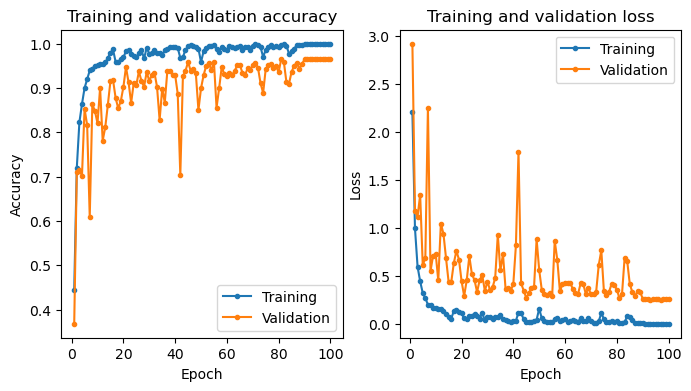

In [11]:
tf_utils.plot_history(history)

tf_utils.save_json(f'{FPATH}/{model_dir_name}/history.json', history.history)

In [12]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 74s 278ms/step - loss: 0.2518 - accuracy: 0.9595
Kaggle set evaluation: 
Test loss: 0.251787006855011
Test accuracy: 0.9594953656196594


1/1 [==============================] - 1s 1s/step


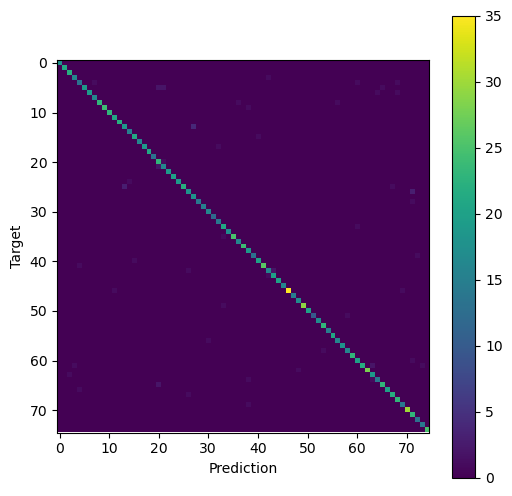

In [13]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m,figsize=(6,6))
plt.show()

In [14]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 3s 224ms/step - loss: 1.5628 - accuracy: 0.7754
Nature set evaluation: 
Test loss: 1.5628365278244019
Test accuracy: 0.7753623127937317


1/1 [==============================] - 0s 34ms/step


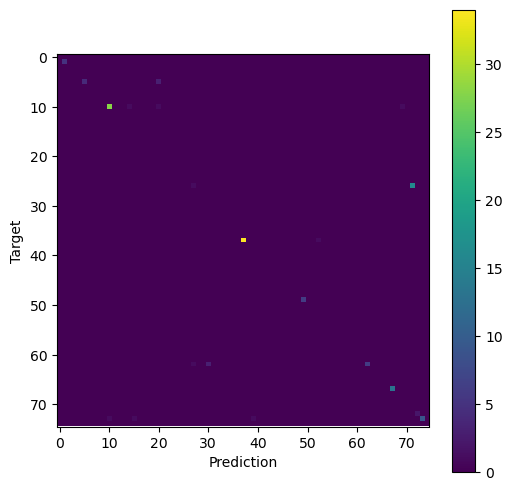

In [15]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m,figsize=(6,6))
plt.show()

In [18]:
# Evaluating inference time
t0 = time()
model.predict(kaggle_ds)
t1 = time()
inf_time = (t1 - t0) * 1000 / 10033
print(f'The average inference time: {inf_time:.2f}ms')

314/314 [==============================] - 88s 259ms/step


In [19]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'batch_size': BATCH_SIZE,
    'seed': SEED,
    'epochs': EPOCHS,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'inference_time': inf_time,
    'comment': '',
    'test_confusion': m.tolist(),
    'nature_confusion': nature_m.tolist()
    }

tf_utils.save_json(f'{FPATH}/{model_dir_name}/info.json', info)